In [5]:
import pandas as pd
import os
import glob

monthly_token_data = {}

BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
MONTHS = ["apr23", "may23", "jun23", "jul23", "aug23", "sep23", "oct23", "nov23", "dec23", "jan24"]  

def parse_timestamp(ts):
    try:
        return pd.to_datetime(ts, utc=True)
    except Exception:
        try:
            return pd.to_datetime(ts, unit='s', utc=True)
        except Exception:
            return pd.NaT

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()

            if 'timestamp' not in df.columns or 'close' not in df.columns or 'volume' not in df.columns:
                print(f"⚠️ Skipping {token} — required columns missing")
                continue

            df['timestamp'] = df['timestamp'].apply(parse_timestamp)
            df = df.dropna(subset=['timestamp'])  # drop rows where timestamp couldn't be parsed
            df = df.sort_values(by='timestamp').reset_index(drop=True)

            df['days_since_launch'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.days
            df = df.drop_duplicates(subset='days_since_launch')  # In case timestamps are repeated

            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})

        except Exception as e:
            print(f"⚠️ Error loading {token}: {e}")

    if month_prices and month_volumes:
        try:
            aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
            aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

            monthly_token_data[month] = {
                "prices": aligned_prices,
                "volumes": aligned_volumes
            }

            print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")

        except Exception as e:
            print(f"❌ Failed to align {month}: {e}")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded apr23: 5 tokens, 350 days
✅ Loaded may23: 5 tokens, 321 days
✅ Loaded jun23: 5 tokens, 196 days
✅ Loaded jul23: 5 tokens, 373 days
❌ Skipped aug23: No valid token data found
❌ Skipped sep23: No valid token data found
✅ Loaded oct23: 5 tokens, 333 days
✅ Loaded nov23: 4 tokens, 381 days
✅ Loaded dec23: 5 tokens, 256 days
✅ Loaded jan24: 5 tokens, 372 days



📦 Loaded 15 unique tokens total.

📅 Window 1: Launch = days 0-29, Hold = 30-59
Top 5 tokens launched in this window: ['TURT', 'BIGTIME', 'GROK', 'MUBI', '1CAT']

📅 Window 2: Launch = days 30-59, Hold = 60-89
Top 5 tokens launched in this window: ['MUBI', 'GROK', 'TITANX', 'TURT', 'PEAS']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_9957/4255542488.py:90: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


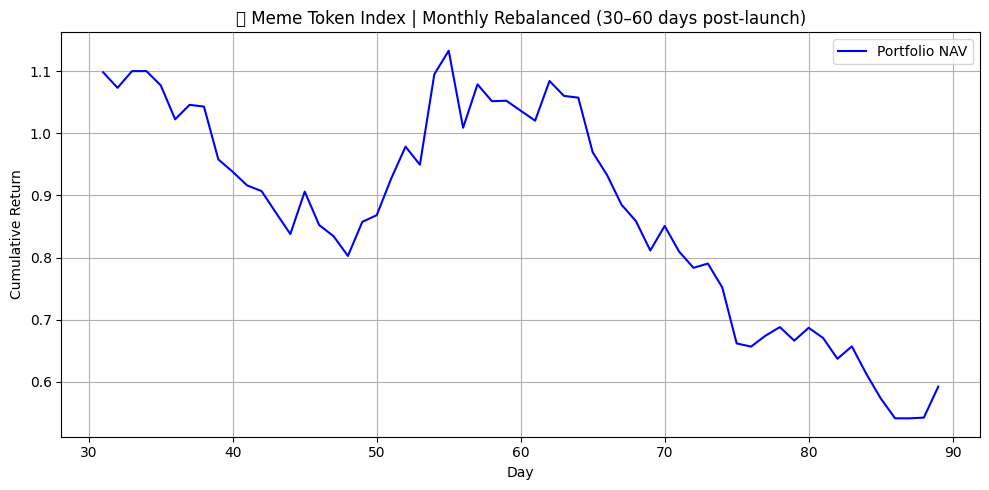

In [6]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/memetoken-index-RC5/dataframes/"
ALL_MONTHS = ["apr23", "oct23", "nov23", "dec23"]
MONTH_RANGES = [(0, 29), (30, 59), (60, 89)] 

# Step 1: Load ALL tokens from ALL folders
all_token_data = {}
for month in ALL_MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        if token in all_token_data:
            continue  # avoid duplicate
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue
            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            all_token_data[token] = df
        except Exception as e:
            print(f"⚠️ Error loading {token}: {e}")

print(f"\n📦 Loaded {len(all_token_data)} unique tokens total.")

# Step 2: Loop over each month window, rebalance
portfolio_returns = []

for i, (launch_start, launch_end) in enumerate(MONTH_RANGES[:-1]):
    hold_start, hold_end = MONTH_RANGES[i + 1]
    print(f"\n📅 Window {i+1}: Launch = days {launch_start}-{launch_end}, Hold = {hold_start}-{hold_end}")

    # 2A: Pick tokens launched in this range
    candidates = []
    for token, df in all_token_data.items():
        if df['days_since_launch'].min() <= launch_start and df['days_since_launch'].max() >= hold_end:
            df_launch = df[(df['days_since_launch'] >= launch_start) & (df['days_since_launch'] <= launch_end)]
            if len(df_launch) < 10:
                continue
            total_vol = df_launch['volume'].sum()
            candidates.append((token, total_vol))

    if len(candidates) < 5:
        print("⚠️ Not enough tokens launched in this window.")
        continue

    # 2B: Sort by volume and take top 5
    candidates.sort(key=lambda x: x[1], reverse=True)
    top_tokens = [t[0] for t in candidates[:5]]
    print(f"Top 5 tokens launched in this window: {top_tokens}")

    # 2C: Get price data from day 30–59
    price_data = []
    for token in top_tokens:
        df = all_token_data[token]
        df_hold = df[(df['days_since_launch'] >= hold_start) & (df['days_since_launch'] <= hold_end)]
        if df_hold.shape[0] < 2:
            print(f"❌ Skipping {token}, insufficient hold period data.")
            continue
        price_series = df_hold[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
        price_data.append(price_series)

    if len(price_data) < 2:
        print("⚠️ Not enough valid price series for portfolio.")
        continue

    combined_prices = pd.concat(price_data, axis=1).ffill().bfill()
    daily_returns = combined_prices.pct_change().dropna()
    equal_weighted = daily_returns.mean(axis=1)
    portfolio_returns.append(equal_weighted)

# Step 3: Plot cumulative NAV
if portfolio_returns:
    nav = pd.concat(portfolio_returns)
    cumulative_nav = (1 + nav).cumprod()

    plt.figure(figsize=(10, 5))
    plt.plot(cumulative_nav, label="Portfolio NAV", color="blue")
    plt.title("📈 Meme Token Index | Monthly Rebalanced (30–60 days post-launch)")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("🚫 No valid portfolio returns to plot.")


### 1. Lookahead Bias Portfolio for each month

📈 apr23: Final return over 30 days = 1090.85%
📈 may23: Final return over 30 days = 2340.34%
📈 jun23: Final return over 30 days = -21.38%
📈 jul23: Final return over 30 days = -3.31%
📈 oct23: Final return over 30 days = 1020.37%
📈 nov23: Final return over 30 days = 723.57%
📈 dec23: Final return over 30 days = 341.46%
📈 jan24: Final return over 30 days = 1051.9%


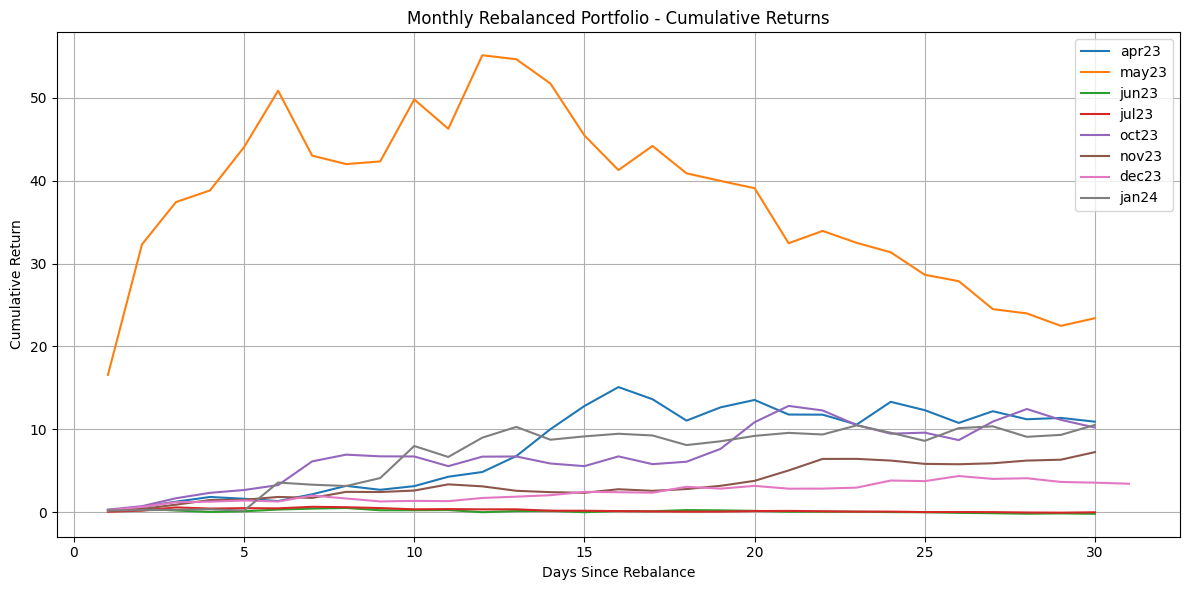

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

results = {}

# Rebalancing period in days
HOLD_DAYS = 30

for month, data in monthly_token_data.items():
    prices = data['prices'].copy()

    # Ensure prices are sorted by days_since_launch
    prices = prices.sort_index()

    # Compute daily returns for each token
    daily_returns = prices.pct_change().dropna()

    # Define rebalance point
    if daily_returns.shape[0] < HOLD_DAYS:
        print(f"⚠️ Skipping {month}: Not enough days to backtest ({daily_returns.shape[0]} days)")
        continue

    # Equal weights
    n_tokens = daily_returns.shape[1]
    weights = pd.Series(1 / n_tokens, index=daily_returns.columns)

    # Slice returns for the holding period
    held_returns = daily_returns.iloc[:HOLD_DAYS]

    # Portfolio daily returns (weighted average of token returns)
    portfolio_returns = held_returns @ weights

    # Cumulative return
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    # Store results
    results[month] = {
        'portfolio_returns': portfolio_returns,
        'cumulative_returns': cumulative_returns,
        'final_return': cumulative_returns.iloc[-1]
    }

    print(f"📈 {month}: Final return over {HOLD_DAYS} days = {round(cumulative_returns.iloc[-1]*100, 2)}%")

# Plotting all cumulative returns
plt.figure(figsize=(12, 6))
for month, res in results.items():
    plt.plot(res['cumulative_returns'], label=month)
plt.title("Monthly Rebalanced Portfolio - Cumulative Returns")
plt.xlabel("Days Since Rebalance")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Relative Time Analysis

In [11]:
import pandas as pd

HOLD_DAYS = 30  # we want to backtest over day 30 to day 60 (30 days)

results = {}

for month, data in monthly_token_data.items():
    prices = data['prices'].copy()
    
    # Make sure index is integer days_since_launch
    prices.index = prices.index.astype(int)
    
    # Select the backtest period (day 30 to day 59 inclusive)
    backtest_prices = prices[(prices.index >= 30) & (prices.index < 60)]
    
    if backtest_prices.shape[0] < HOLD_DAYS:
        print(f"⚠️ Skipping {month}: Not enough data for days 30-60 ({backtest_prices.shape[0]} days)")
        continue
    
    # Calculate daily returns
    daily_returns = backtest_prices.pct_change().dropna()
    
    # Equal weights across all tokens available in this period
    n_tokens = daily_returns.shape[1]
    weights = pd.Series(1 / n_tokens, index=daily_returns.columns)
    
    # Portfolio returns as weighted average
    portfolio_returns = daily_returns @ weights
    
    # Cumulative returns for the backtest period
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    
    results[month] = {
        'portfolio_returns': portfolio_returns,
        'cumulative_returns': cumulative_returns,
        'final_return': cumulative_returns.iloc[-1]
    }
    
    print(f"📈 {month}: Final return from day 30 to day 60 = {cumulative_returns.iloc[-1]*100:.2f}%")


📈 apr23: Final return from day 30 to day 60 = -42.25%
📈 may23: Final return from day 30 to day 60 = -34.86%
📈 jun23: Final return from day 30 to day 60 = -16.15%
📈 jul23: Final return from day 30 to day 60 = -0.98%
📈 oct23: Final return from day 30 to day 60 = 26.61%
📈 nov23: Final return from day 30 to day 60 = -5.31%
📈 dec23: Final return from day 30 to day 60 = -35.56%
📈 jan24: Final return from day 30 to day 60 = 122.36%


🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in oct23: ['HAY', 'JOE', 'TITANX', 'LMI', 'KIZUNA']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['HAY', 'JOE', 'TITANX', 'LMI', 'KIZUNA']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['HAY', 'JOE', 'TITANX', 'LMI', 'KIZUNA']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_9957/580082318.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


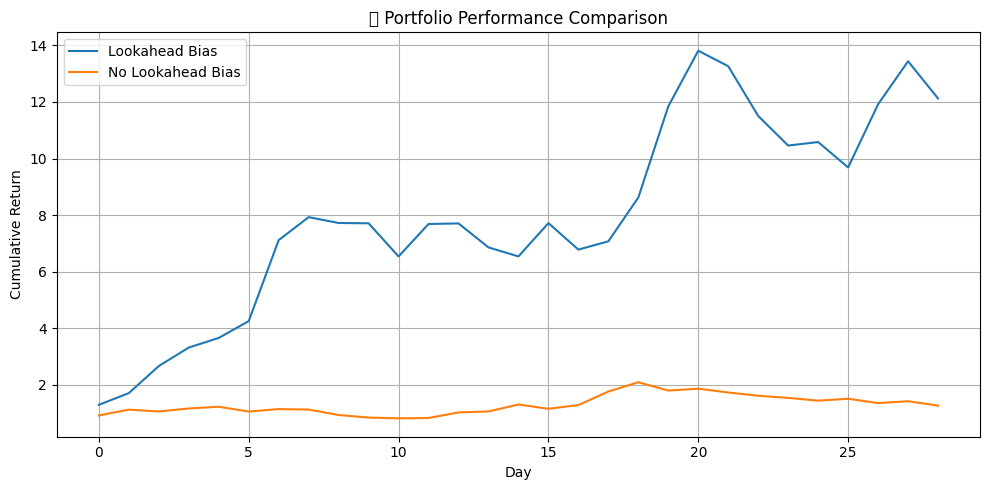


📊 Lookahead Bias Portfolio:
        Total Return: 1112.59%
   Annualized Return: 4363703996972147.50%
        Sharpe Ratio: 9.94
        Max Drawdown: -29.88%

📊 No Lookahead Bias Portfolio:
        Total Return: 26.61%
   Annualized Return: 1849.37%
        Sharpe Ratio: 2.31
        Max Drawdown: -39.47%


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "oct23" 

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


🔍 Loading files...
📦 Loaded 4 tokens.
📊 Top tokens by volume in nov23: ['GROK', 'MUBI', 'WETH', 'MEME']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['GROK', 'MUBI', 'WETH', 'MEME']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–59): ['GROK', 'MUBI', 'WETH', 'MEME']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_9957/2550358097.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


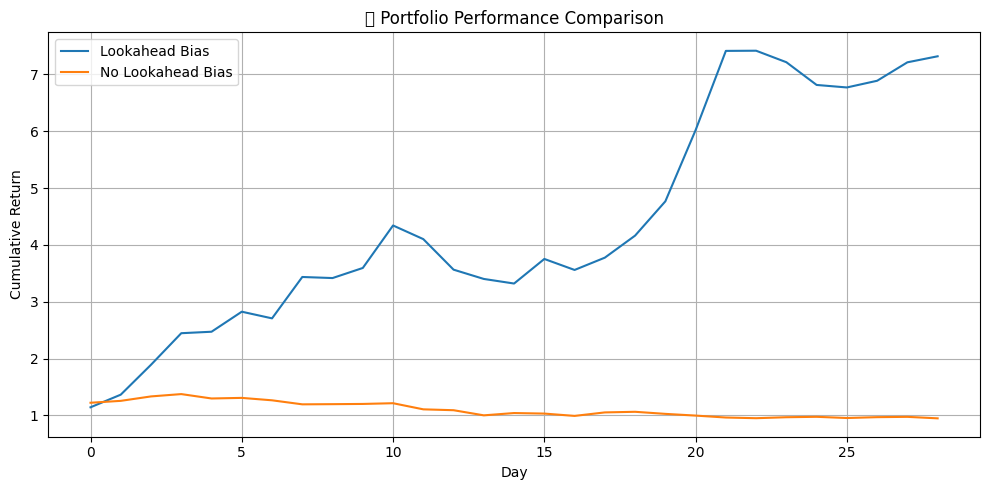


📊 Lookahead Bias Portfolio:
        Total Return: 631.85%
   Annualized Return: 7582843334590.48%
        Sharpe Ratio: 11.61
        Max Drawdown: -23.54%

📊 No Lookahead Bias Portfolio:
        Total Return: -5.31%
   Annualized Return: -49.65%
        Sharpe Ratio: -0.14
        Max Drawdown: -31.06%


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 59
MONTH = "nov23" 

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")
